In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
from datetime import datetime
from collections import Counter
from collections import defaultdict
from matplotlib.dates import date2num, num2date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import nltk

# Web Scraping

### *Obtaining All Names (using genshin.gg)*

In [2]:
#Web scraping the wikia for Genshin's playable character list.
#Note: Scraping only one page from .gg

urlnames_gg = "https://genshin.gg/"

pagenames_gg = requests.get(urlnames_gg)

soupname_gg = BeautifulSoup(pagenames_gg.text, "html.parser")

In [3]:
#Scraping through to get the html, identifying which class and identifier to find the names

imgtag_gg = soupname_gg.find_all("h2", class_= "character-name")
#imgtag_gg

In [4]:
characters_gg = [element.get_text() for element in imgtag_gg]
#characters

def process_names(names_list):                                        #Create Function to change all capital
    return [name.replace(" ", "").lower() for name in names_list]

characters_gg = process_names(characters_gg)
characters_gg = sorted(characters_gg)

#print(characters_gg)

## Data Preprocessing

### *Tidying Up Names*

In [5]:
remove_gg = ["itto", "kazuha", "heizou", "sara", "childe", "ayato", "ayaka", "kokomi"]

characters_gg = [item for item in characters_gg if item not in remove_gg]
characters_gg = characters_gg + remove_gg
#print(characters_gg)

### *Scraping Names and Dates from g8*

In [6]:
url_g8 = "https://game8.co/games/Genshin-Impact/archives/307054"


#Using the Built-in Pandas html reader
pandas_table_g8 = pd.read_html(url_g8)

dates_full_g8 = pandas_table_g8[7]        #Selecting the correct table with the release date from the scrape

#Removing the irrelevant data
dates_full_g8 = dates_full_g8.drop(columns = ['Element'])
dates_full_g8 = dates_full_g8.dropna()

#Sorting values
dates_full_g8 = dates_full_g8.sort_values(by = ["Character"], axis = 0)
dates_full_g8.reset_index(drop=True, inplace=True)


#Fixing Aloy, Childe, and Kuki Shinobu: specific characters with issues that need to be processed manually
#with the naming and release date conventions
dates_full_g8.loc[2, 'Release Date'] = "10/13/2021"
dates_full_g8.loc[44, 'Character'] = "childe"
dates_full_g8 = dates_full_g8.drop(dates_full_g8[dates_full_g8['Character'] == "Shinobu"].index)


#Fixing Rarity Tag
dates_full_g8['Rarity'] = dates_full_g8['Rarity'].str.replace(r'★ (\d+)', r'\1star', regex=True)    #use Regex

#Fixing Release Date
dates_full_g8['Release Date'] = pd.to_datetime(dates_full_g8['Release Date'])


#Converting character names into simpler format and obtaining information on missing ("Day One") Characters
characters_g8 = dates_full_g8['Character'].tolist()
characters_g8 = [x.lower() for x in characters_g8]        #Similar to previous action with gg
characters_g8 = process_names(characters_g8)              #Use Previous function to remove spaces


#Listing out Missing Characters, comparing complete set FROM gg and the incomplete from g8
characters_gg_g8 = list(set(characters_gg) - set(characters_g8))


#Isolating Day 1 Characters into g8
characters_gg_g8 = list(set(characters_gg_g8) - set('kukishinobu'))    #kukishinobu will be added back later


#Creating 5star (legendary) and 4star (epic) dataframes for concatenation
Legendary = ['diluc', 'jean', 'traveler(geo)', 'traveler(electro)', 
             'traveler(hydro)','traveler(anemo)', 'traveler(dendro)', 
             'qiqi', 'mona', 'keqing']
Epic = list(set(characters_gg_g8) - set(Legendary))        #Manual action is listing Day One Legendary characters


#Converting Epic list into DataFrame
df_Epic = pd.DataFrame(Epic, columns=['Character'])
df_Epic['Rarity'] = '4star'
df_Epic['Release Date'] = '2020/9/28'
df_Epic['Release Date'] = pd.to_datetime(df_Epic['Release Date'])

kuki = pd.DataFrame([{'Character': 'kukishinobu',         #Adding back kukishinobu manually
                      'Rarity': '4star', 
                      'Release Date': '21/6/2022'}])
kuki['Release Date'] = pd.to_datetime(kuki['Release Date'])


df_Epic = pd.concat([df_Epic, kuki])
df_Epic.reset_index(drop = True, inplace = True)


#Converting Legendary list into DataFrame
df_Legend = pd.DataFrame(Legendary, columns=['Character'])
df_Legend['Rarity'] = '5star'
df_Legend['Release Date'] = '2020/9/28'
df_Legend['Release Date'] = pd.to_datetime(df_Epic['Release Date'])


#Combining the 5s and 4s dataframes for the Day One Characters (and kukishinobu)
df_Day1 = pd.concat([df_Epic, df_Legend])
df_Day1.reset_index(drop = True, inplace = True)


#Combining the Day One Characters with the Initial dates_full_g8 Frame
dates_full_g8 = pd.concat([dates_full_g8, df_Day1])
dates_full_g8.reset_index(inplace = True, drop = True)

In [7]:
characters_g8 = dates_full_g8['Character'].tolist()
characters_g8 = [x.lower() for x in characters_g8]
characters_g8 = process_names(characters_g8)

#print(len(dates_full_g8))
#dates_full_g8

#print(len(characters_g8))
#characters_g8

### *Scraping Character Data from genshin.gg*

Skip to next section for pd.read_csv, to avoid unecessary web scraping

In [12]:
#Web Scraping Constellation Data from Genshin.gg - Complete

characters_gg_test = characters_g8#[0:60]
cons_full_g8 = []

for names in characters_gg_test:
    
    url_chara_gg = "https://genshin.gg/characters/"+names+"/"
    page_chara_gg = requests.get(url_chara_gg)
    soup_chara_gg = BeautifulSoup(page_chara_gg.content, "html.parser")
 

    #Obtaining the constellation html info
    
    if soup_chara_gg.find("div", id='constellations') != None:
        cons1 = soup_chara_gg.find("div", id="constellations").find_all("div", class_="character-skill-description")
        cons2 = [con.get_text() for con in cons1]
        cons2 = " ".join(cons2)
        #print(cons2)
        cons_full_g8.append(cons2)
    
    else:
        #print("No Constellations")
        notext = "This character has no constellations."
        cons_full_g8.append(notext)

In [70]:
len(cons_full_g8)

#cons_full_g8
#dates_full_g8

#Note: Set limit as desired
pd.set_option('display.max_rows', 10)

In [71]:
#Adding the constellation descriptions into the ready-made dataframe
dates_full_g8['Constellation Description'] = cons_full_g8

#Renaming into new DF
df1 = dates_full_g8
#display(df1)

In [73]:
#Generating a simple word count from the constellation descriptions and adding it as a new column

List_count_g8 = []

for paragraph in cons_full_g8:
    words = paragraph.split()
    word_count = sum(Counter(words).values())
    List_count_g8.append(word_count)

#print(List_count_g8)
#len(List_count_g8)

df1['Word Count'] = List_count_g8

### *Save dataframe into csv for convenience*

Select file path/directory as required

In [15]:
#Saving Output from Data Frame 1 into csv (to decrease uneccesary web scrape loading) part 2

#df1.to_csv("/Users/ignatiustobiassoetjianto/Desktop/df1_wc.csv", index = False)

In [31]:
df1 = pd.read_csv('/Users/ignatiustobiassoetjianto/Desktop/Project/BEE2041_Project/Data_files/df1_wc.csv')
df1['Release Date'] = pd.to_datetime(df1['Release Date'])
display(df1)

,Release Date,Character,Rarity,Constellation Description,Word Count
0,2020-12-23,Albedo,5star,Transient Blossoms generated by Albedo's Abiog...,141
1,2023-01-18,Alhaitham,5star,"When a Projection Attack hits an opponent, Uni...",252
2,2021-10-13,Aloy,5star,This character has no constellations.,5
3,2021-07-01,Ayaka,5star,When Kamisato Ayaka's Normal or Charged Attack...,138
4,2022-03-30,Ayato,5star,Shunsuiken DMG is increased by 40% against opp...,121
...,...,...,...,...,...
80,2020-09-28,traveler(anemo),5star,Palm Vortex pulls in enemies within a 5m radiu...,80
81,2020-09-28,traveler(dendro),5star,"After Razorgrass Blade hits an opponent, it wi...",126
82,2020-09-28,qiqi,5star,When the Herald of Frost hits an enemy marked ...,102
83,2020-09-28,mona,5star,The effects of Hydro-related Elemental Reactio...,165


# Functions

In [9]:
#Create Function that count specific words/strings

def count_target_words(Input, Target):
    words = Input.split()
    count = 0
    
    
    for target in Target:
        for word in words:
#        word = word.strip('.,?!:;-()[]{}\'"')
    
            if word == target:
                count += 1
    
    return count

In [32]:
#Creating new Function to generate new dataframe column "Key Count"

def create_key_count_col(dataframe):

    key_words = ['crit', 'energy', 'increase', 'increases', 'decrease', 'decreases', 'recharge', 'atk',
                 'dmg', 'elemental', 'element', 'refund', 'attacks', 'reaction', 'reactions', 'attack']
    
    test1 = dataframe#.drop(columns = ['Word Count'])
    
    if 'Constellation Desc' in test1.columns and 'Key Count' in test1.columns:
        return test1
    
    else:
        test1.loc[:, 'Constellation Desc'] = test1['Constellation Description'].replace(".", "").replace('(', "").replace(')', "")
        test1.loc[:, 'Constellation Desc'].apply(lambda x: x.lower())
        test1 = test1.drop(columns = ['Constellation Description'])

        #Aggregate of all "Meaningful" key word stats.
        test1['Key Count'] = test1['Constellation Desc'].apply(lambda x: count_target_words(x, key_words))
                                                           
    return test1


In [27]:
#Creating a function to make the subplot system


def get_keyword_count_scatter(dataframe):

    #Setting Subplots
    dataframe_TEST, ax = plt.subplots(1, 2, figsize=(12, 5))

    #Checking Rarity
    rarity_types = dataframe['Rarity'].unique().tolist()

#    dataframe = create_key_count_col(dataframe)        #Create column using create_key_count_col

    dataframe = create_key_count_col(dataframe)        #Create column using create_key_count_col

    
    
    #Scatter Plot
    if len(rarity_types) == 2:
        
        X1_test = dataframe['Release Date']                #Generate Data
        X1_test_int = X1_test.astype(int)
        Y1_test = dataframe['Key Count']
        dataframe_set = np.polyfit(X1_test_int, Y1_test, 1)
        dataframe_line = np.poly1d(dataframe_set)
        r_value = np.corrcoef(X1_test_int, Y1_test)[0, 1]
        
        ax[0].scatter(X1_test, Y1_test, color='blue',
                      marker = 'o', edgecolor = 'black', alpha = 0.75, s = 150)

        ax[0].set_xlabel('Release Date', fontweight = "bold")
        ax[0].set_ylabel('Key Words Count', fontweight = "bold")
        ax[0].set_title('Scatter Plot of Character Constellation key words overtime')

    else:        
        X1_test = dataframe['Release Date']
        X1_test_int = X1_test.astype(int)
        Y1_test = dataframe['Key Count']
        dataframe_set = np.polyfit(X1_test_int, Y1_test, 1)
        dataframe_line = np.poly1d(dataframe_set)
        r_value = np.corrcoef(X1_test_int, Y1_test)[0, 1]
        
        if dataframe['Rarity'][0] == '4star':
            ax[0].scatter(X1_test, Y1_test, color='#945dc4',
                          marker = 'o', edgecolor = 'black', alpha = 0.75, s = 150)

            ax[0].set_xlabel('Release Date', fontweight = "bold")
            ax[0].set_ylabel('Key Words Count', fontweight = "bold")
            ax[0].set_title('Scatter Plot of 4 star Character key words overtime')
            ax[0].set_ylim(0, 18


        else:
            ax[0].scatter(X1_test, Y1_test, color='#dca454',
                          marker = 'o', edgecolor = 'black', alpha = 0.75, s = 150)

            ax[0].set_xlabel('Release Date', fontweight = "bold")
            ax[0].set_ylabel('Key Words Count', fontweight = "bold")
            ax[0].set_title('Scatter Plot of 5 star Character key words overtime')
            ax[0].set_ylim(0, 18)

    #Line of Best Fit
    ax[1].plot(X1_test_int, dataframe_line(X1_test_int), color = 'red', 
               label = f'Line of Best Fit (r={r_value:.3f})')

    ax[1].set_xlabel('Time', fontweight = "bold")
    ax[1].set_ylabel('Key Words Count', fontweight = "bold")
    ax[1].set_title('Line of Best Fit')
    ax[1].set_ylim(0, 18)

    #Formatting x-axis
    for axis in ax:
        axis.tick_params(axis = 'x', rotation=30)
        axis.grid(True)
    
    
    #Display the plot
    plt.tight_layout()
    plt.legend()
    plt.show()

SyntaxError: invalid syntax (2239945809.py, line 53)

In [12]:
#Creating a function to make a histogram subplots


def get_keyword_count_histogram(dataframe):
    
    #Aggregating all descriptions into one paragraph.
    dataframe_cons_all = ' '.join(dataframe['Constellation Description'])

    #Cleaning the paragraph
    testing1 = dataframe_cons_all.replace(".", "").replace('(', "").replace(')', "")
    testing2 = testing1.lower().split()                #Splitting paragraphs by word
    testing3 = Counter(testing2).most_common(15)       #Making a word count and distribution
                                                       #Choose the top frequencies as desired
 
    #Converting into usable DataFrame
    testing4 = pd.DataFrame(testing3, columns=['Word', 'Frequency'])
    testing4 = testing4[::-1]

    #Check rarities contained in dataframe
    rarity_types = dataframe['Rarity'].unique().tolist()

    #Plotting into bar chart
    if len(rarity_types) == 2:                         #Checks if there is only one or two rarities
        plt.barh(testing4['Word'], testing4['Frequency'], color = "blue")
        plt.xlabel('Frequency', fontsize = 11, fontweight = 'bold')
        plt.ylabel('Words', fontsize = 10, fontweight = 'bold')
        plt.title('Word Frequency Distribution of Character Constellations')
        plt.xticks(rotation=0, fontsize = 10)

    else:
        if dataframe['Rarity'][0] == '4star':
            plt.barh(testing4['Word'], testing4['Frequency'], color = "#945dc4")
            plt.xlabel('Frequency', fontsize = 11, fontweight = 'bold')
            plt.ylabel('Words', fontsize = 10, fontweight = 'bold')
            plt.title('Word Frequency Distribution of 4star Constellations')
            plt.xticks(rotation=0, fontsize = 10)
        
        else:
            plt.barh(testing4['Word'], testing4['Frequency'], color = "#dca454")
            plt.xlabel('Frequency', fontsize = 11, fontweight = 'bold')
            plt.ylabel('Words', fontsize = 10, fontweight = 'bold')
            plt.title('Word Frequency Distribution of 5star Constellations')
            plt.xticks(rotation=0, fontsize = 10)
 
    plt.show()

# Data Processing

## *Plots (no discrimination)*

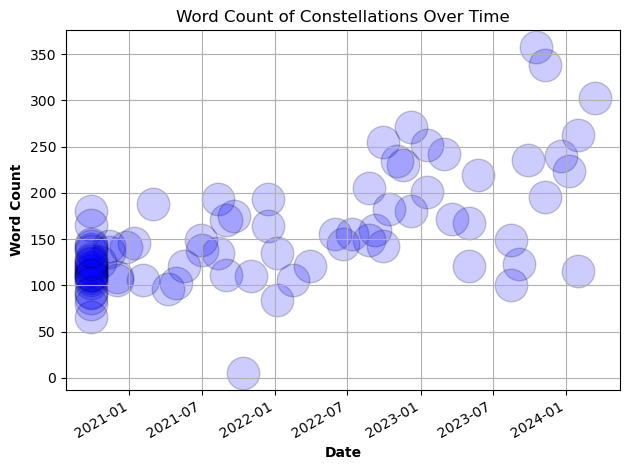

In [13]:
#Creating plots with the new data frame.

df1.plot.scatter(x='Release Date', y = 'Word Count', color = 'blue',
                 marker = 'o', edgecolor = 'black', alpha = 0.20, s=550)

# Adding labels and title
plt.xlabel('Date', fontweight = 'bold')
plt.ylabel('Word Count', fontweight = 'bold')
plt.title('Word Count of Constellations Over Time')

# Formatting x-axis ticks as dates
plt.xticks(rotation=30, ha='right')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

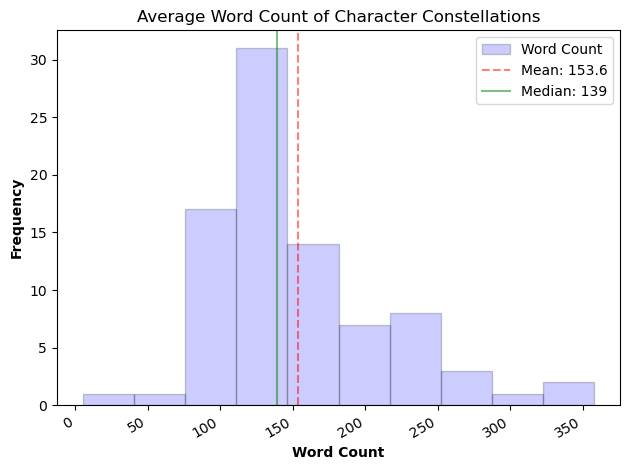

In [14]:
#Histogram of Frequency of "Word Count:" Average Word Count of Character Constellations

df1.plot.hist(y='Word Count', color='blue', edgecolor='black', alpha = 0.20)

#Calculate Mean and Median
mean_stat = df1['Word Count'].mean()
median_stat = df1['Word Count'].median()

plt.axvline(x=mean_stat, color = 'red', linestyle = '--', 
            label = f'Mean: {round(mean_stat, 1)}', alpha = 0.5)
plt.axvline(x=median_stat, color = 'green', linestyle = '-', 
            label = f'Median: {round(median_stat)}', alpha = 0.5)


#Adding labels and title
plt.xlabel('Word Count', fontweight = 'bold')
plt.ylabel('Frequency', fontweight = 'bold')
plt.title('Average Word Count of Character Constellations')
plt.legend()

#Formatting x-axis ticks as dates
plt.xticks(rotation=30, ha='right')

#Display the plot
plt.tight_layout()
plt.show()

In [15]:
#Summary Statistics of Word Count

df1_summary = df1.describe()
display(df1_summary)

,Word Count
count,85.000000
mean,153.564706
std,60.457669
min,5.000000
25%,111.000000
50%,139.000000
75%,180.000000
max,358.000000


## *Grouping by Rarity*

Creating initial dataframes for 4 star and 5 star characters.

In [16]:
#Summary Statistics according to character rarity

df1_summary = df1.groupby('Rarity')
display(df1_summary.mean())

,Word Count
Rarity,
4star,136.950000
5star,168.333333


In [17]:
#Splitting original dataframe into a list, and then converting the list into a pd.DataFrame

Rarity = df1.groupby('Rarity')
df1_Rarity = [group_df for _, group_df in Rarity]
df1_Epic, df1_Legendary = df1_Rarity

In [18]:
df1_Epic.reset_index(inplace = True, drop = True)
df1_Legendary.reset_index(inplace = True, drop = True)

#display(df1_Epic)
#display(df1_Legendary)

## *Scatter Plots (with discrimination)*

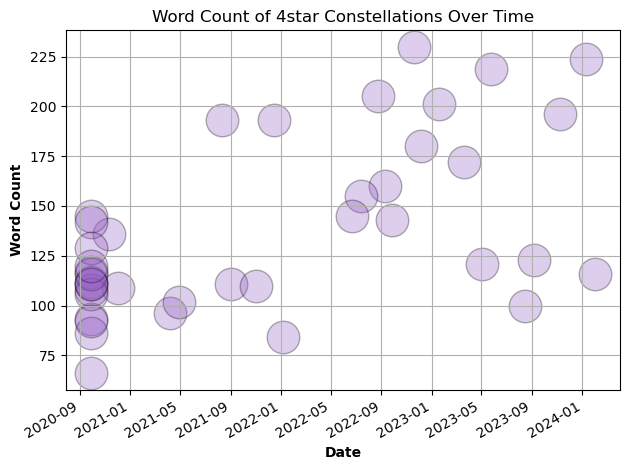

In [19]:
#Creating plots for Epic Rarities

df1_Epic.plot.scatter(x = 'Release Date', y = 'Word Count', color='#945dc4',
                 marker = 'o', edgecolor = 'black', alpha = 0.30, s = 550)

# Adding labels and title
plt.xlabel('Date', fontweight = 'bold')
plt.ylabel('Word Count', fontweight = 'bold')
plt.title('Word Count of 4star Constellations Over Time')

# Formatting x-axis ticks as dates
plt.xticks(rotation=30, ha='right')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

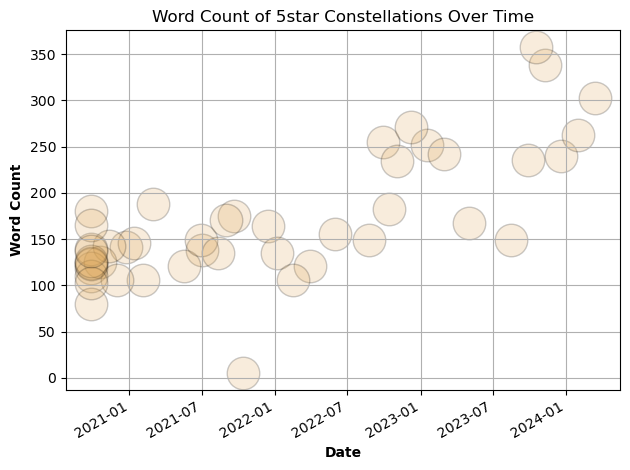

In [20]:
#Creating plots for Legendary Rarities

df1_Legendary.plot.scatter(x = 'Release Date', y = 'Word Count', color = '#dca454',
                 marker = 'o', edgecolor = 'black', alpha = 0.20, s = 550)

# Adding labels and title
plt.xlabel('Date', fontweight = 'bold')
plt.ylabel('Word Count', fontweight = 'bold')
plt.title('Word Count of 5star Constellations Over Time')

# Formatting x-axis ticks as dates
plt.xticks(rotation=30, ha='right')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

## *Insight: word frequency distribution*
Using previously created functions

In [21]:
pd.set_option('display.max_rows', 10)

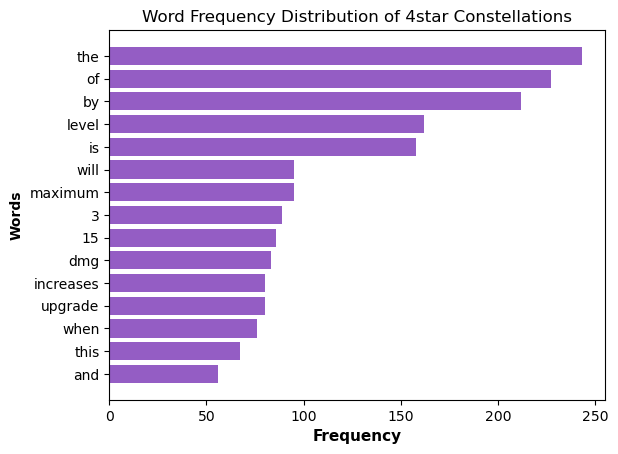

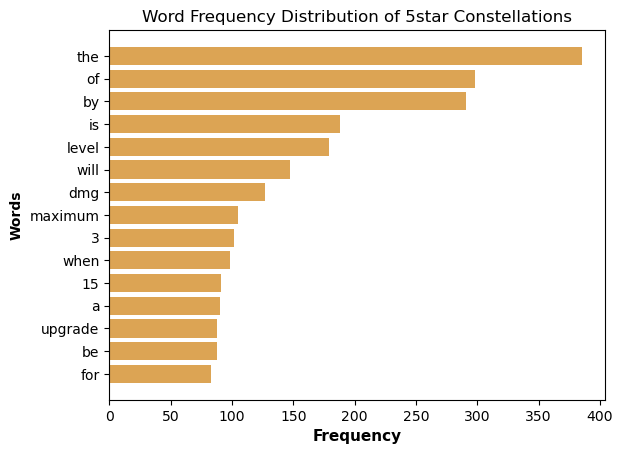

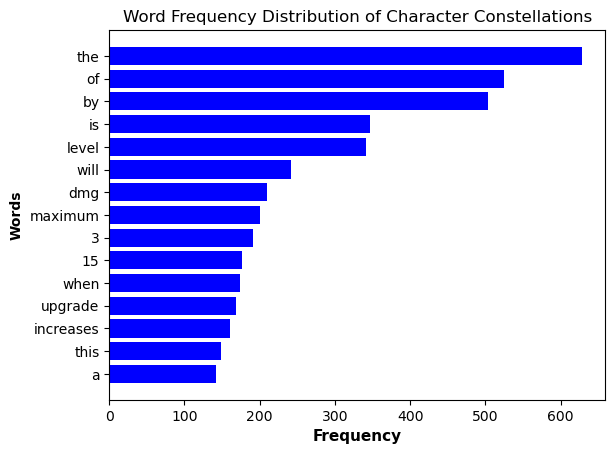

In [22]:
get_keyword_count_histogram(df1_Epic)
get_keyword_count_histogram(df1_Legendary)
get_keyword_count_histogram(df1)

In [34]:
df1

#create_key_count_col(df1)

,Release Date,Character,Rarity,Constellation Description,Word Count,Constellation Desc
0,2020-12-23,Albedo,5star,Transient Blossoms generated by Albedo's Abiog...,141,Transient Blossoms generated by Albedo's Abiog...
1,2023-01-18,Alhaitham,5star,"When a Projection Attack hits an opponent, Uni...",252,"When a Projection Attack hits an opponent, Uni..."
2,2021-10-13,Aloy,5star,This character has no constellations.,5,This character has no constellations.
3,2021-07-01,Ayaka,5star,When Kamisato Ayaka's Normal or Charged Attack...,138,When Kamisato Ayaka's Normal or Charged Attack...
4,2022-03-30,Ayato,5star,Shunsuiken DMG is increased by 40% against opp...,121,Shunsuiken DMG is increased by 40% against opp...
...,...,...,...,...,...,...
80,2020-09-28,traveler(anemo),5star,Palm Vortex pulls in enemies within a 5m radiu...,80,Palm Vortex pulls in enemies within a 5m radiu...
81,2020-09-28,traveler(dendro),5star,"After Razorgrass Blade hits an opponent, it wi...",126,"After Razorgrass Blade hits an opponent, it wi..."
82,2020-09-28,qiqi,5star,When the Herald of Frost hits an enemy marked ...,102,When the Herald of Frost hits an enemy marked ...
83,2020-09-28,mona,5star,The effects of Hydro-related Elemental Reactio...,165,The effects of Hydro-related Elemental Reactio...


## *Insight: "Quality" of Constellations*
Using previous created functions

In [23]:
pd.set_option('display.max_rows', 10)

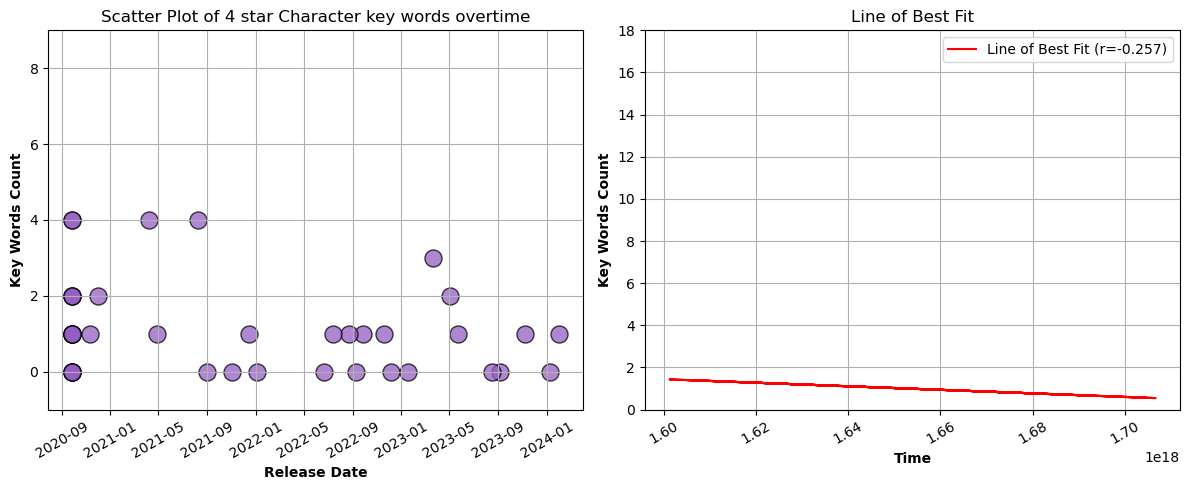

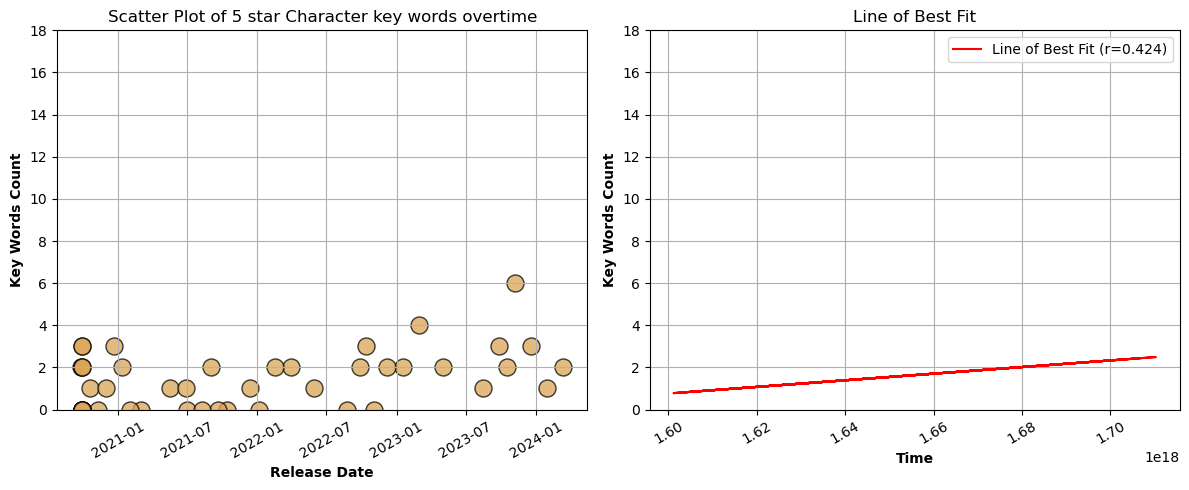

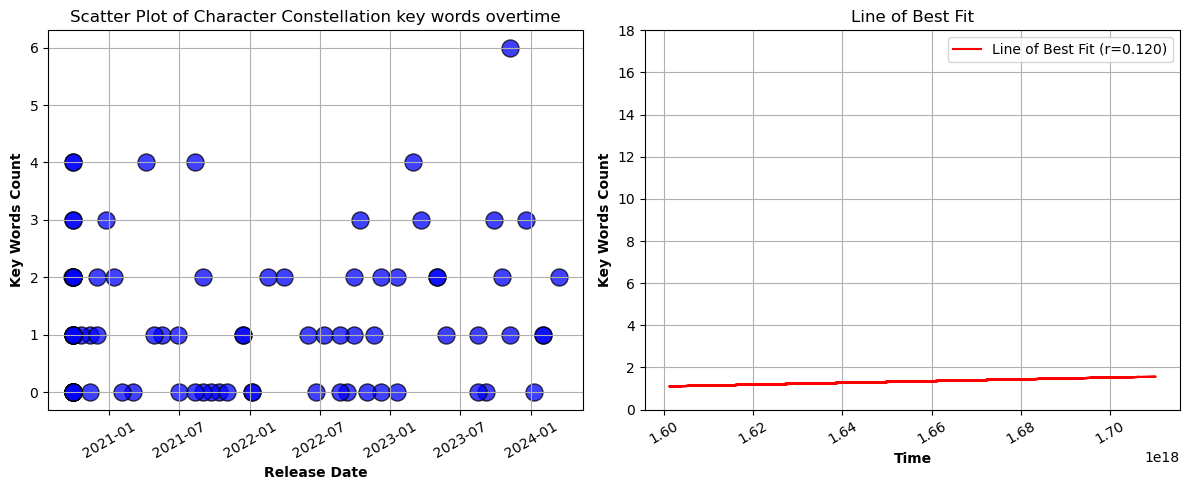

In [28]:
get_keyword_count_scatter(df1_Epic)
get_keyword_count_scatter(df1_Legendary)
get_keyword_count_scatter(df1)

# Testing

In [114]:
#Modifying Excluding Day ONE character Testing

x = '2020/9/28'
x = datetime.strptime(x, '%Y/%m/%d')

df_alter = df1[df1['Release Date'] != x]
df_alter.reset_index(drop = True, inplace = True)
display(df_alter)

,Release Date,Character,Rarity,Constellation Description,Word Count,Constellation Desc
0,2020-12-23,Albedo,5star,Transient Blossoms generated by Albedo's Abiog...,141,transient blossoms generated by albedo's abiog...
1,2023-01-18,Alhaitham,5star,"When a Projection Attack hits an opponent, Uni...",252,"when a projection attack hits an opponent, uni..."
2,2021-10-13,Aloy,5star,This character has no constellations.,5,this character has no constellations.
3,2021-07-01,Ayaka,5star,When Kamisato Ayaka's Normal or Charged Attack...,138,when kamisato ayaka's normal or charged attack...
4,2022-03-30,Ayato,5star,Shunsuiken DMG is increased by 40% against opp...,121,shunsuiken dmg is increased by 40% against opp...
...,...,...,...,...,...,...
55,2022-05-31,Yelan,5star,Lingering Lifeline gains 1 additional charge. ...,155,lingering lifeline gains 1 additional charge. ...
56,2021-08-10,Yoimiya,5star,The Auros Blaze created by Ryuukin Saxifrage l...,135,the auros blaze created by ryuukin saxifrage l...
57,2022-01-05,Yun Jin,4star,Opening Flourish's CD is decreased by 18%. Aft...,84,opening flourish's cd is decreased by 18%. aft...
58,2020-12-01,Zhongli,5star,Increases the maximum number of Stone Steles c...,106,increases the maximum number of stone steles c...


/var/folders/kp/jtxv8nk91mj813v9rp3sbkb00000gn/T/ipykernel_4359/2274387424.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1.loc[:, 'Constellation Desc'] = test1['Constellation Description'].replace(".", "").replace('(', "").replace(')', "")


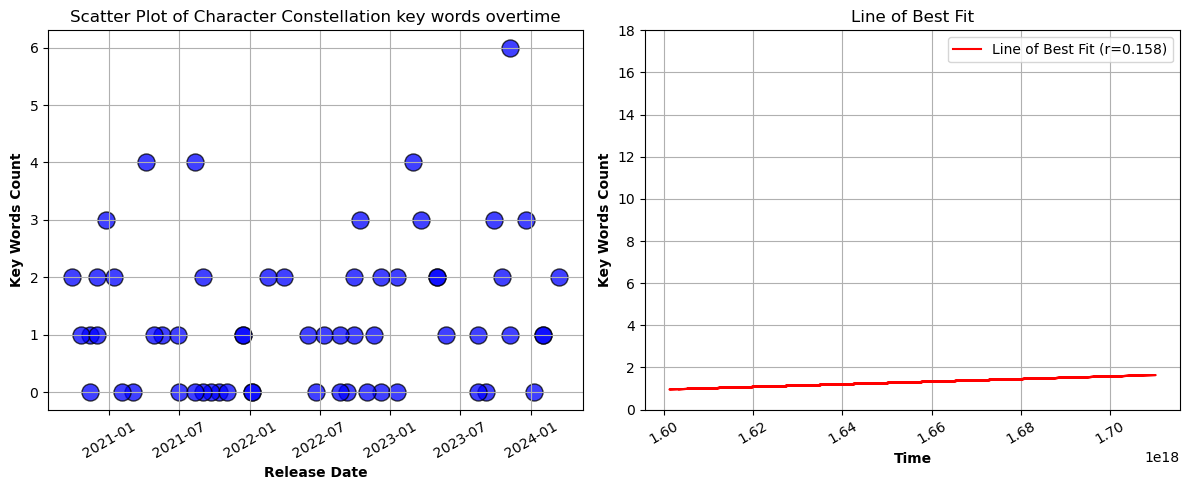

In [115]:
get_keyword_count_scatter(df_alter)

In [116]:
create_key_count_col(df_alter)

/var/folders/kp/jtxv8nk91mj813v9rp3sbkb00000gn/T/ipykernel_4359/2274387424.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1.loc[:, 'Constellation Desc'] = test1['Constellation Description'].replace(".", "").replace('(', "").replace(')', "")


,Release Date,Character,Rarity,Word Count,Constellation Desc,Key Count
0,2020-12-23,Albedo,5star,141,Transient Blossoms generated by Albedo's Abiog...,3
1,2023-01-18,Alhaitham,5star,252,"When a Projection Attack hits an opponent, Uni...",2
2,2021-10-13,Aloy,5star,5,This character has no constellations.,0
3,2021-07-01,Ayaka,5star,138,When Kamisato Ayaka's Normal or Charged Attack...,0
4,2022-03-30,Ayato,5star,121,Shunsuiken DMG is increased by 40% against opp...,2
...,...,...,...,...,...,...
55,2022-05-31,Yelan,5star,155,Lingering Lifeline gains 1 additional charge. ...,1
56,2021-08-10,Yoimiya,5star,135,The Auros Blaze created by Ryuukin Saxifrage l...,0
57,2022-01-05,Yun Jin,4star,84,Opening Flourish's CD is decreased by 18%. Aft...,0
58,2020-12-01,Zhongli,5star,106,Increases the maximum number of Stone Steles c...,1


In [56]:
df_alter

,Release Date,Character,Rarity,Constellation Description,Word Count,Constellation Desc
0,2020-12-23,Albedo,5star,Transient Blossoms generated by Albedo's Abiog...,141,transient blossoms generated by albedo's abiog...
1,2023-01-18,Alhaitham,5star,"When a Projection Attack hits an opponent, Uni...",252,"when a projection attack hits an opponent, uni..."
2,2021-10-13,Aloy,5star,This character has no constellations.,5,this character has no constellations.
3,2021-07-01,Ayaka,5star,When Kamisato Ayaka's Normal or Charged Attack...,138,when kamisato ayaka's normal or charged attack...
4,2022-03-30,Ayato,5star,Shunsuiken DMG is increased by 40% against opp...,121,shunsuiken dmg is increased by 40% against opp...
...,...,...,...,...,...,...
30,2021-02-03,Xiao,5star,Increases Lemniscatic Wind Cycling's charges b...,106,increases lemniscatic wind cycling's charges b...
31,2022-02-16,Yae Miko,5star,Each time Great Secret Art: Tenko Kenshin acti...,106,each time great secret art: tenko kenshin acti...
32,2022-05-31,Yelan,5star,Lingering Lifeline gains 1 additional charge. ...,155,lingering lifeline gains 1 additional charge. ...
33,2021-08-10,Yoimiya,5star,The Auros Blaze created by Ryuukin Saxifrage l...,135,the auros blaze created by ryuukin saxifrage l...


In [61]:
df_alter_test = df_alter

#df_alter_test['Constellation Desc'] = df_alter_test['Constellation Description'].apply(lambda x: x.replace(".", "").replace('(', "").replace(')', ""))


df_alter_test.get('Constellation Desc').replace(".", "").replace('(', "").replace(')', "")

0     Transient Blossoms generated by Albedo's Abiog...
1     When a Projection Attack hits an opponent, Uni...
2                  This character has no constellations
3     When Kamisato Ayaka's Normal or Charged Attack...
4     Shunsuiken DMG is increased by 40% against opp...
                            ...                        
30    Increases Lemniscatic Wind Cycling's charges b...
31    Each time Great Secret Art: Tenko Kenshin acti...
32    Lingering Lifeline gains 1 additional charge W...
33    The Auros Blaze created by Ryuukin Saxifrage l...
34    Increases the maximum number of Stone Steles c...
Name: Constellation Desc, Length: 35, dtype: object

In [97]:
#Creating new Function to generate new dataframe column "Key Count"

def create_key_count_col_test(dataframe):

    key_words = ['crit', 'energy', 'increase', 'increases', 'decrease', 'decreases', 'recharge', 'atk',
                 'dmg', 'elemental', 'element', 'refund', 'attacks', 'reaction', 'reactions', 'attack']
    
    test1 = dataframe#.drop(columns = ['Word Count'])
    
    if 'Constellation Desc' in test1.columns and 'Key Count' in test1.columns:
        return test1
    
    else:
    
        test1.get('Constellation Desc').replace(".", "").replace('(', "").replace(')', "")

#df['Text'] = df['Text'].apply(lambda x: x.lower())
       
        # test1['Constellation Desc'] = test1['Constellation Desc'].apply(lambda x: x.lower())
    
        test1.loc[:, 'Constellation Desc'].apply(lambda x: x.lower())    
    
        #test1.drop(columns = ['Constellation Description'])

#Aggregate of all "Meaningful" key word stats.
        test1.loc[:, 'Key Count'] = test1['Constellation Desc'].apply(lambda x: count_target_words(x, key_words))
    
    test1.drop(columns = ['Constellation Description'])

    return test1


In [29]:
create_key_count_col_test(df1_alter)

NameError: name 'create_key_count_col_test' is not defined

In [82]:
df1_alter.loc[:, 'Constellation Desc'].apply()

TypeError: apply() missing 1 required positional argument: 'func'